In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error as rmse

# Load the data
train_data = pd.read_parquet("data/train_data.parquet")
test_data = pd.read_parquet("data/test_data.parquet")

# Convert expiry to datetime if it's not already
if train_data["expiry"].dtype != "datetime64[ns]":
    train_data["expiry"] = pd.to_datetime(train_data["expiry"])

# Get the target expiry date
target_date = pd.Timestamp("2025-05-08").date()


In [3]:
data_path = "data"
output_path = "output/"
temp_path = "tmp/"

sample_submission = pd.read_csv(f"{data_path}/sample_submission.csv")
submission_cols = sample_submission.columns.tolist()

In [4]:
# Filter rows with the specified expiry date
expiry_filter = train_data['expiry'].dt.date == target_date
target_rows = train_data[expiry_filter]

# Get indices of rows to be used for validation (50% of the rows with target expiry)
validation_indices = target_rows.sample(frac=0.5, random_state=43).index

# Create validation set
val_data = train_data.loc[validation_indices].copy()

# Remove validation data from training set
train_data = train_data.drop(validation_indices)

# Print shapes to confirm
print(f"Original training data shape: {len(train_data) + len(val_data)}")
print(f"New training data shape: {train_data.shape}")
print(f"Validation data shape: {val_data.shape}")
print(f"Test data shape: {test_data.shape}")

Original training data shape: 178340
New training data shape: (138752, 97)
Validation data shape: (39588, 97)
Test data shape: (12065, 96)


In [5]:
test_data.columns

Index(['timestamp', 'underlying', 'call_iv_24000', 'call_iv_24100',
       'call_iv_24200', 'call_iv_24300', 'call_iv_24400', 'call_iv_24500',
       'call_iv_24600', 'call_iv_24700', 'call_iv_24800', 'call_iv_24900',
       'call_iv_25000', 'call_iv_25100', 'call_iv_25200', 'call_iv_25300',
       'call_iv_25400', 'call_iv_25500', 'call_iv_25600', 'call_iv_25700',
       'call_iv_25800', 'call_iv_25900', 'call_iv_26000', 'call_iv_26100',
       'call_iv_26200', 'call_iv_26300', 'call_iv_26400', 'call_iv_26500',
       'put_iv_23000', 'put_iv_23100', 'put_iv_23200', 'put_iv_23300',
       'put_iv_23400', 'put_iv_23500', 'put_iv_23600', 'put_iv_23700',
       'put_iv_23800', 'put_iv_23900', 'put_iv_24000', 'put_iv_24100',
       'put_iv_24200', 'put_iv_24300', 'put_iv_24400', 'put_iv_24500',
       'put_iv_24600', 'put_iv_24700', 'put_iv_24800', 'put_iv_24900',
       'put_iv_25000', 'put_iv_25100', 'put_iv_25200', 'put_iv_25300',
       'put_iv_25400', 'put_iv_25500', 'X0', 'X1', 'X2',

In [6]:
train_data.columns

Index(['timestamp', 'underlying', 'expiry', 'call_iv_23500', 'call_iv_23600',
       'call_iv_23700', 'call_iv_23800', 'call_iv_23900', 'call_iv_24000',
       'call_iv_24100', 'call_iv_24200', 'call_iv_24300', 'call_iv_24400',
       'call_iv_24500', 'call_iv_24600', 'call_iv_24700', 'call_iv_24800',
       'call_iv_24900', 'call_iv_25000', 'call_iv_25100', 'call_iv_25200',
       'call_iv_25300', 'call_iv_25400', 'call_iv_25500', 'call_iv_25600',
       'call_iv_25700', 'call_iv_25800', 'call_iv_25900', 'call_iv_26000',
       'put_iv_22500', 'put_iv_22600', 'put_iv_22700', 'put_iv_22800',
       'put_iv_22900', 'put_iv_23000', 'put_iv_23100', 'put_iv_23200',
       'put_iv_23300', 'put_iv_23400', 'put_iv_23500', 'put_iv_23600',
       'put_iv_23700', 'put_iv_23800', 'put_iv_23900', 'put_iv_24000',
       'put_iv_24100', 'put_iv_24200', 'put_iv_24300', 'put_iv_24400',
       'put_iv_24500', 'put_iv_24600', 'put_iv_24700', 'put_iv_24800',
       'put_iv_24900', 'put_iv_25000', 'X0', '

In [7]:
pred_cols = list(
    filter(
        lambda x: x.startswith("call") or x.startswith("put"), val_data.columns.tolist()
    )
)
len(pred_cols)

52

## Setting 32 columns to nan randomly in each row

In [8]:
import os
if os.path.exists(f"{temp_path}/sample_val.csv") and os.path.exists(
    f"{temp_path}/val_Y.csv"
):
    # If the sample files already exist, load them
    sample_val = pd.read_csv(f"{temp_path}/sample_val.csv")
    val_Y = pd.read_csv(f"{temp_path}/val_Y.csv")
    print("Loaded existing sample_val and val_Y.")
else:
    # Create a copy of val_data to avoid modifying the original
    sample_val = val_data.copy()

    # Get the call and put columns separately
    call_cols = [col for col in pred_cols if col.startswith("call")]
    put_cols = [col for col in pred_cols if col.startswith("put")]

    # For each row, randomly select 16 call columns and 16 put columns to set to NaN
    for idx in sample_val.index:
        # Randomly select 16 call columns for this row
        nan_call_cols = np.random.choice(call_cols, size=16, replace=False)

        # Randomly select 16 put columns for this row
        nan_put_cols = np.random.choice(put_cols, size=16, replace=False)

        # Set these columns to NaN for this row
        sample_val.loc[idx, nan_call_cols] = np.nan
        sample_val.loc[idx, nan_put_cols] = np.nan

    # Create val_Y from the original validation data, containing only the target columns
    val_Y = val_data[pred_cols]
    sample_val.to_csv(f"{temp_path}/sample_val.csv", index=False)
    val_Y.to_csv(f"{temp_path}/val_Y.csv", index=False)

Loaded existing sample_val and val_Y.


In [16]:
sample_val[pred_cols].shape

(39588, 52)

In [17]:
sample_val[pred_cols].isna().sum().sum()

1266816

## Matching done in matching.cpp 
run using following two commands
```sh
make
./csv_processor input.csv output.csv
```

In [27]:
sample_val.isna().sum().sum()

1266816

In [24]:
sample_val[pred_cols]

,call_iv_23500,call_iv_23600,call_iv_23700,call_iv_23800,call_iv_23900,call_iv_24000,call_iv_24100,call_iv_24200,call_iv_24300,call_iv_24400,...,put_iv_24100,put_iv_24200,put_iv_24300,put_iv_24400,put_iv_24500,put_iv_24600,put_iv_24700,put_iv_24800,put_iv_24900,put_iv_25000
0,0.435793,NaN,NaN,0.35605,0.323607,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.170470,0.159481,NaN,NaN,0.179010,NaN,0.199894
1,0.206319,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.155349,NaN,0.143520,0.139684,NaN,NaN,NaN,NaN,0.142821,0.143361
2,NaN,0.270770,NaN,NaN,0.199588,0.173109,NaN,NaN,NaN,0.092642,...,NaN,0.126261,NaN,NaN,0.094310,NaN,0.125152,NaN,NaN,0.172376
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.180702,0.159274,...,0.244192,NaN,NaN,NaN,0.151899,NaN,0.170842,NaN,NaN,0.206709
4,0.211074,NaN,0.196625,NaN,0.181550,NaN,NaN,NaN,NaN,NaN,...,NaN,0.160637,NaN,NaN,NaN,NaN,NaN,NaN,0.140879,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39583,NaN,0.266833,NaN,NaN,0.199508,NaN,NaN,0.127681,0.105612,NaN,...,0.151432,0.127059,NaN,NaN,0.093166,NaN,NaN,0.136707,NaN,0.168649
39584,0.424743,NaN,0.360815,NaN,NaN,NaN,0.216435,0.177320,0.139397,NaN,...,0.217862,0.177957,0.139287,NaN,0.131736,0.153389,NaN,NaN,NaN,0.238655
39585,NaN,NaN,0.197977,NaN,NaN,0.169431,NaN,NaN,NaN,NaN,...,0.162073,NaN,NaN,NaN,NaN,NaN,0.134736,0.134442,NaN,NaN
39586,NaN,0.239076,NaN,NaN,0.190411,NaN,NaN,NaN,0.127195,NaN,...,0.156536,0.140845,NaN,0.116940,NaN,0.109931,NaN,0.122428,0.131322,0.139958


In [22]:
matched = pd.read_csv(f"{temp_path}/matched.csv", header=None)
matched.columns = pred_cols
matched

,call_iv_23500,call_iv_23600,call_iv_23700,call_iv_23800,call_iv_23900,call_iv_24000,call_iv_24100,call_iv_24200,call_iv_24300,call_iv_24400,...,put_iv_24100,put_iv_24200,put_iv_24300,put_iv_24400,put_iv_24500,put_iv_24600,put_iv_24700,put_iv_24800,put_iv_24900,put_iv_25000
0,0.435793,0.408857,NaN,0.356050,0.323607,0.291889,NaN,0.224415,0.194234,NaN,...,0.258032,0.224524,0.194070,0.170470,0.159481,0.161023,0.167537,0.179010,0.191029,0.199894
1,0.206319,0.196255,0.188493,0.178193,NaN,NaN,NaN,NaN,NaN,0.139371,...,0.155349,NaN,0.143520,0.139684,0.137495,0.136912,0.137545,0.139502,0.142821,0.143361
2,NaN,0.270770,0.246826,NaN,0.199588,0.173109,NaN,NaN,0.105375,0.092642,...,NaN,0.126261,0.105485,0.092562,0.094310,0.108690,0.125152,0.140007,0.155576,0.172376
3,0.423425,NaN,0.373041,0.343406,0.310602,NaN,NaN,NaN,0.180702,0.159274,...,0.244192,0.211284,0.181348,0.159464,0.151899,NaN,0.170842,NaN,NaN,0.206709
4,0.211074,0.204527,0.196625,0.189597,0.181550,0.174704,0.166497,0.160109,0.154867,NaN,...,0.166912,0.160637,0.154380,0.149688,0.145748,NaN,0.140894,0.139796,0.140879,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39583,0.286794,0.266833,0.246634,0.222294,0.199508,NaN,0.151167,0.127681,0.105612,0.092508,...,0.151432,0.127059,0.105614,0.091928,0.093166,NaN,0.119958,0.136707,0.145752,0.168649
39584,0.424743,0.392405,0.360815,0.329439,0.294188,0.255974,0.216435,0.177320,0.139397,0.121526,...,0.217862,0.177957,0.139287,0.122533,0.131736,0.153389,0.172040,0.187483,0.200873,0.238655
39585,0.216417,0.207829,0.197977,0.188510,0.179600,0.169431,0.161560,0.154212,0.147385,0.142324,...,0.162073,0.154545,0.147658,0.142029,0.138399,0.135967,0.134736,0.134442,0.135468,-0.000000
39586,0.255594,0.239076,0.221726,0.206437,0.190411,0.173214,0.156353,0.140827,0.127195,0.116924,...,0.156536,0.140845,0.126932,0.116940,0.110905,0.109931,0.113149,0.122428,0.131322,0.139958


In [25]:
matched.isna().sum().sum()

317203

In [29]:
# Calculate the average number of NaN values per row in the matched dataframe
avg_nan_per_row = matched.isna().sum(axis=1).mean()
print(f"Avg NaN per row: {avg_nan_per_row:.2f}")

# Also show the distribution of NaN counts per row
nan_counts_per_row = matched.isna().sum(axis=1)
print(f"Min NaN per row: {nan_counts_per_row.min()}")
print(f"Max NaN per row: {nan_counts_per_row.max()}")
print(f"Std NaN per row: {nan_counts_per_row.std():.2f}")

Avg NaN per row: 8.01
Min NaN per row: 0
Max NaN per row: 20
Std NaN per row: 4.02


# Then Quadratic Fitting

In [30]:
sample_val[pred_cols] = matched[pred_cols]

In [31]:
sample_val.isna().sum().sum()

317203

In [32]:
# Extract strike prices from column names
call_strike_prices = np.array(
    [float(col.split("_")[-1]) for col in pred_cols if col.startswith("call")]
)
put_strike_prices = np.array(
    [float(col.split("_")[-1]) for col in pred_cols if col.startswith("put")]
)

# Initialize dataframe to store predictions
preds = pd.DataFrame(index=sample_val.index, columns=pred_cols)


# Function to perform quadratic regression for a single row
def quad_regression_predict(row, strike_prices, option_type):
    # Get column names for this option type
    cols = [col for col in pred_cols if col.startswith(option_type)]

    # Get non-NaN values and their corresponding strike prices
    valid_mask = ~row[cols].isna()
    valid_cols = np.array(cols)[valid_mask]

    if len(valid_cols) < 3:  # Need at least 3 points for quadratic regression
        return None

    y_vals = row[valid_cols].values.astype(np.float64)
    x_vals = np.array([float(col.split("_")[-1]) for col in valid_cols])
    # Perform quadratic regression
    coeffs = np.polyfit(x_vals, y_vals, 2)
    poly = np.poly1d(coeffs)

    # Predict for all strike prices of this option type
    all_strikes = strike_prices
    predictions = pd.Series(
        poly(all_strikes),
        index=[f"{option_type}_iv_{int(strike)}" for strike in all_strikes],
    )
    # predictions[valid_cols] = row[valid_cols].astype(np.float64)  # Keep original values for known strikes
    return predictions


# Apply regression for each row
for idx in sample_val.index:
    # Process call options
    call_predictions = quad_regression_predict(
        sample_val.loc[idx], call_strike_prices, "call"
    )
    if call_predictions is not None:
        preds.loc[idx, call_predictions.index] = call_predictions

    # Process put options
    put_predictions = quad_regression_predict(
        sample_val.loc[idx], put_strike_prices, "put"
    )
    if put_predictions is not None:
        preds.loc[idx, put_predictions.index] = put_predictions

# Fill in any missing values using original values (if any regression failed)
for col in pred_cols:
    nan_mask = preds[col].isna()
    if nan_mask.any():
        preds.loc[nan_mask, col] = sample_val.loc[nan_mask, col]

# Calculate RMSE between predictions and actual values
rmse_val = rmse(val_Y.values.flatten(), preds.values.flatten())
print(f"RMSE of quadratic regression prediction: {rmse_val}")

RMSE of quadratic regression prediction: 0.025727085170897394


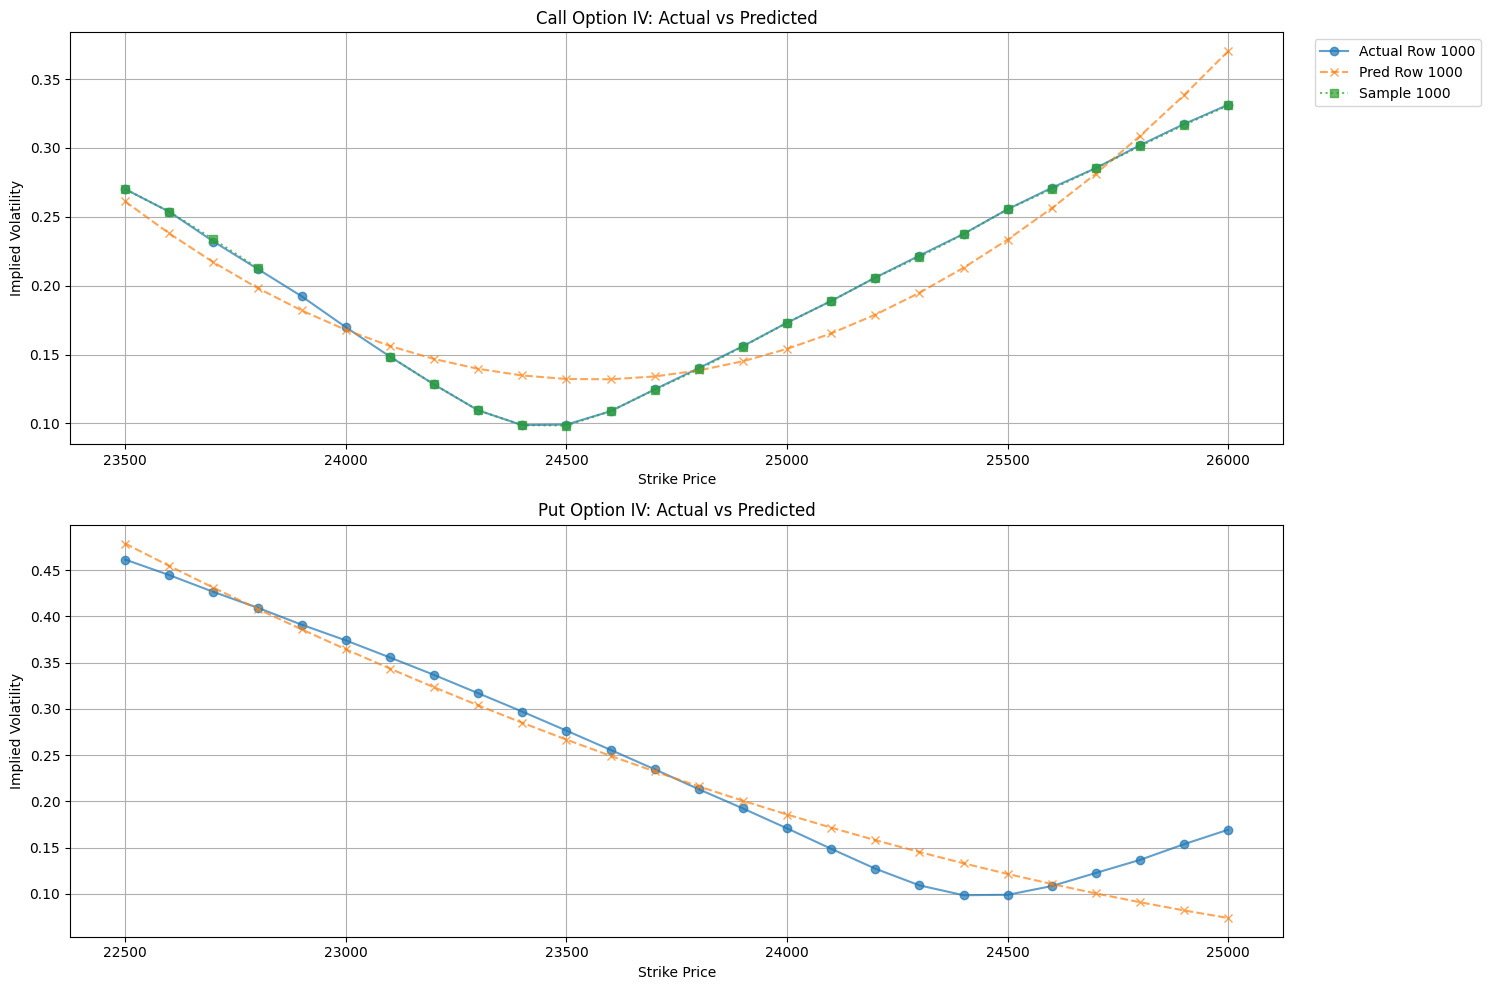

In [33]:
import seaborn as sns

# Create a visualization of val_Y vs preds for specific strikes
import matplotlib.pyplot as plt

# Select a few rows (timestamps) to visualize
sample_indices = [preds.index[1000]]

# Create a figure with subplots - one row for calls, one for puts
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Define strike prices to use in plot
call_strikes = np.array(
    [float(col.split("_")[-1]) for col in pred_cols if col.startswith("call")]
)
put_strikes = np.array(
    [float(col.split("_")[-1]) for col in pred_cols if col.startswith("put")]
)

# Plot for each selected index
for idx in sample_indices:
    # Extract call option data
    call_cols = [col for col in pred_cols if col.startswith("call")]
    call_actual = val_Y.loc[idx, call_cols].values
    call_predicted = preds.loc[idx, call_cols].values
    call_sample = sample_val.loc[idx, call_cols].values

    # Plot call options
    axes[0].plot(call_strikes, call_actual, "o-", alpha=0.7, label=f"Actual {idx}")
    axes[0].plot(
        call_strikes, call_predicted, "x--", alpha=0.7, label=f"Predicted {idx}"
    )
    axes[0].plot(call_strikes, call_sample, "s:", alpha=0.7, label=f"Sample {idx}")

    # Extract put option data
    put_cols = [col for col in pred_cols if col.startswith("put")]
    put_actual = val_Y.loc[idx, put_cols].values
    put_predicted = preds.loc[idx, put_cols].values

    # Plot put options
    axes[1].plot(put_strikes, put_actual, "o-", alpha=0.7)
    axes[1].plot(put_strikes, put_predicted, "x--", alpha=0.7)

# Set titles and labels
axes[0].set_title("Call Option IV: Actual vs Predicted")
axes[0].set_xlabel("Strike Price")
axes[0].set_ylabel("Implied Volatility")
axes[0].grid(True)

axes[1].set_title("Put Option IV: Actual vs Predicted")
axes[1].set_xlabel("Strike Price")
axes[1].set_ylabel("Implied Volatility")
axes[1].grid(True)

# Add a legend to the first subplot only to avoid clutter
handles, labels = axes[0].get_legend_handles_labels()
legend_labels = [
    label.replace("Actual", "Actual Row").replace("Predicted", "Pred Row")
    for label in labels
]
axes[0].legend(handles, legend_labels, loc="upper left", bbox_to_anchor=(1.02, 1))

plt.tight_layout()
plt.show()

In [35]:
test_data.isna().sum().sum()

376504

In [39]:
test_pred_cols = list(
    filter(
        lambda x: x.startswith("call") or x.startswith("put"), test_data.columns.tolist()
    )
)
test_data[test_pred_cols].shape

(12065, 52)

In [37]:
test_data[test_pred_cols].to_csv(f"{temp_path}/pred_test_data.csv", index=False, header=False)